In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import read_parquet
from tqdm import tqdm
%matplotlib inline

In [2]:
# decals_pred = pd.read_table("/data/renhaoye/decals_2022/out_decals_pred.txt", sep="\s+")
# decals_pred['ra'] = "N"
# decals_pred['dec'] = "N"
# for i in tqdm(range(len(decals_pred))):
# # for i in tqdm(range(50)):
#     decals_pred.loc[i, 'ra'] = str(decals_pred.loc[i, 'loc']).split("_")[0]
#     decals_pred.loc[i, 'dec'] = str(decals_pred.loc[i, 'loc']).split("_")[1]
# decals_pred.to_csv("/data/renhaoye/decals_2022/pred_out_decals_0519.csv")
decals_pred = pd.read_csv("/data/renhaoye/decals_2022/pred_out_decals_0519.csv", index_col=0)
labels = ["merger", "round", "between", "cigar", "edgeOn", "noBar", "strongBar"]

In [3]:
from astropy.io import fits
from tqdm import tqdm
with fits.open("/data/renhaoye/decals_2022/MGS_out_DECaLS.fits") as hdul:
    data = np.array(hdul[1].data)
    out = np.zeros((data.shape[0],4))
    # [('VID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('PETROMAG', '>f8', (5,)), ('MODELMAG', '>f8', (5,)), ('FIBERMAG', '>f8', (5,)), ('VAGC_SELECT', '>i4'), ('KCORRECT', '>f8', (5,)), ('Z', '>f8'), ('ZFLAG', '>f8')]
    for i in range(data.shape[0]):
        out[i,0] = data[i]["RA"]
        out[i,1] = data[i]["DEC"]
        out[i,2] = data[i]["PETROMAG"][2]
        out[i,3] = data[i]["Z"]
out = pd.DataFrame(out, columns=["ra","dec","petro_mag", "z"])

In [4]:
out = out.round({"ra": 6, "dec": 6})
decals_pred = decals_pred.round({"ra": 6, "dec": 6})
concat = pd.merge(decals_pred, out, how="inner", on=["ra", "dec"])  # len:457118

In [5]:
decals_csv = "/data/renhaoye/decals_2022/fits.csv"
decals_df = pd.read_csv(decals_csv, index_col=0)
threshold = 0.5
merger = decals_df.query('merging_minor_disturbance_fraction > %f '
                               '| merging_major_disturbance_fraction > %f '
                               '| merging_merger_fraction > %f '
                               % (threshold, threshold, threshold))
smoothRounded = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                              '& how_rounded_round_fraction > %f' % (threshold, threshold))
smoothInBetween = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                                '& how_rounded_in_between_fraction > %f' % (threshold, threshold))
smoothCigarShaped = decals_df.query('smooth_or_featured_smooth_fraction > %f '
                                  '& how_rounded_cigar_shaped_fraction > %f' % (threshold, threshold))
edgeOn = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                       '& disk_edge_on_yes_fraction > %f'
                       % (threshold, threshold))
diskNoBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                          '& disk_edge_on_no_fraction > %f '
                          '& bar_no_fraction > %f '
                          % (threshold, threshold, threshold))
diskStrongBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                              '& disk_edge_on_no_fraction > %f '
                              '&bar_strong_fraction > %f '
                              % (threshold, threshold, threshold))
num_in = [
    len(merger), len(smoothRounded), len(smoothInBetween), len(smoothCigarShaped), len(edgeOn),
    len(diskNoBar), len(diskStrongBar)
]
sum_out, sum_in = 0, 0
for i in num_in:
    sum_in += i
percent_in_decals = [x/sum_in for x in num_in]

In [11]:
def cal_cut(cut):
    num_out=[len(cut.query("label == 0")),
        len(cut.query("label == 1")),
        len(cut.query("label == 2")),
        len(cut.query("label == 3")),
        len(cut.query("label == 4")),
        len(cut.query("label == 5")),
        len(cut.query("label == 6")),
        ]
    sum_out = 0
    for i in num_out:
        sum_out += i
    percent_out_decals = [x/sum_out for x in num_out]
    return percent_out_decals

In [38]:
def show(rg, ax):
    l, r = rg
    if l <0.001:
        l = 0.001
    cut = concat.query("petro_mag < 17.77 and z < %f and z > %f" % (r,l))  # 286909
    percent_out_decals = cal_cut(cut)
    width = 0.4
    x = np.arange(len(labels))
    # fig, ax = plt.subplots(figsize=(15, 6))
    ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
    ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
    # ax.set_ylabel('Percent', fontsize=10)
    ax.set_xticks(x)
    # ax.set_xticklabels(labels)
    # for a,b in zip(x,percent_in_decals): ##控制标签位置
    #     plt.text(a-width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
    # for a,b in zip(x,percent_out_decals): ##控制标签位置
    #     plt.text(a+width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
    # ax.legend(fontsize=10)
    # plt.xlabel("class", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

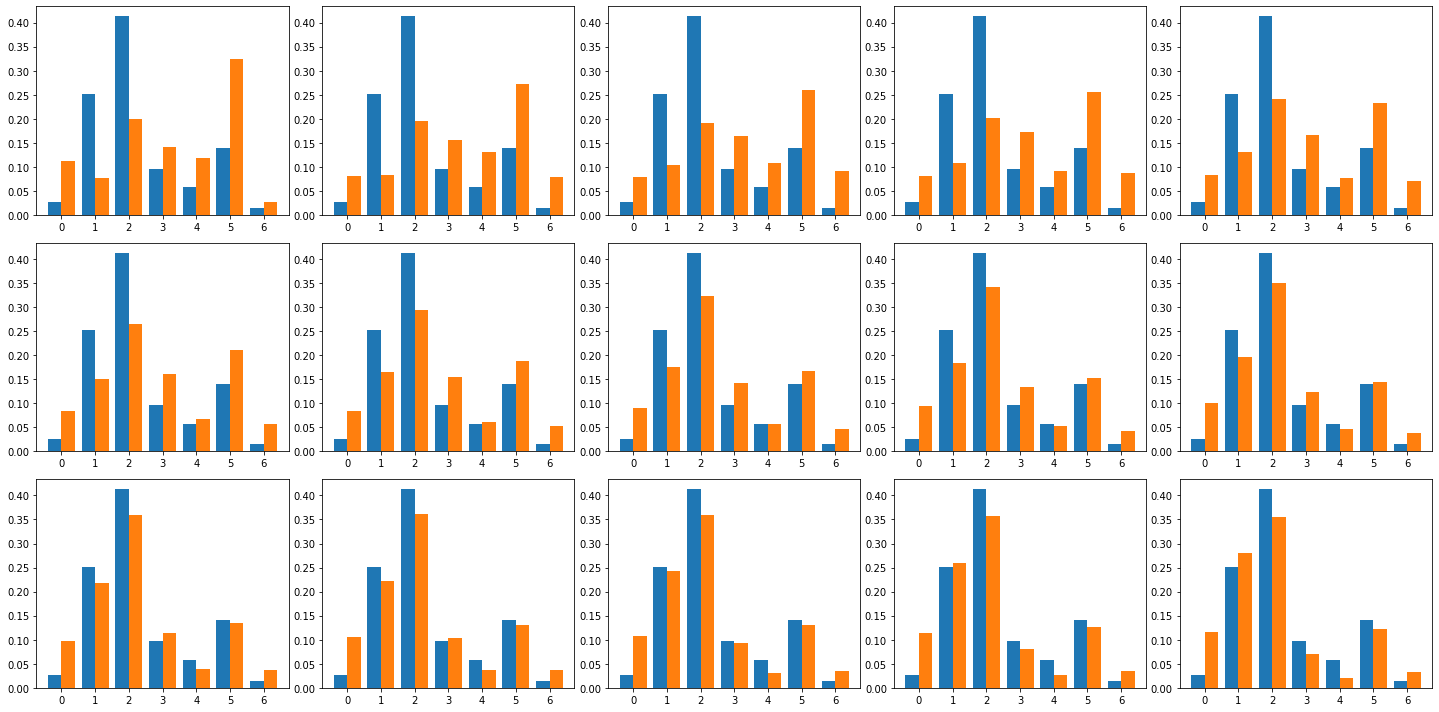

In [39]:
plt.figure(figsize=(20, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    show((i*0.01, (i+1)*0.01), ax)
plt.tight_layout()
plt.show()

In [25]:
# cut = concat
# num_out=[len(cut.query("label == 0")),
#         len(cut.query("label == 1")),
#         len(cut.query("label == 2")),
#         len(cut.query("label == 3")),
#         len(cut.query("label == 4")),
#         len(cut.query("label == 5")),
#         len(cut.query("label == 6")),
#         ]
# sum_out, sum_in = 0, 0
# for i in num_in:
#     sum_in += i
# for i in num_out:
#     sum_out += i
# percent_in_decals = [x/sum_in for x in num_in]
# percent_out_decals = [x/sum_out for x in num_out]
# width = 0.4
# x = np.arange(len(labels))
# fig, ax = plt.subplots(figsize=(15, 10))
# rects1 = ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
# rects2 = ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
# ax.set_ylabel('Percent', fontsize=20)
# # ax.set_title('percent of in/out decals prediction')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# for a,b in zip(x,percent_in_decals): ##控制标签位置
#     plt.text(a-width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
# for a,b in zip(x,percent_out_decals): ##控制标签位置
#     plt.text(a+width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
# ax.legend(fontsize=20)
# # plt.xlabel("class", fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.show()

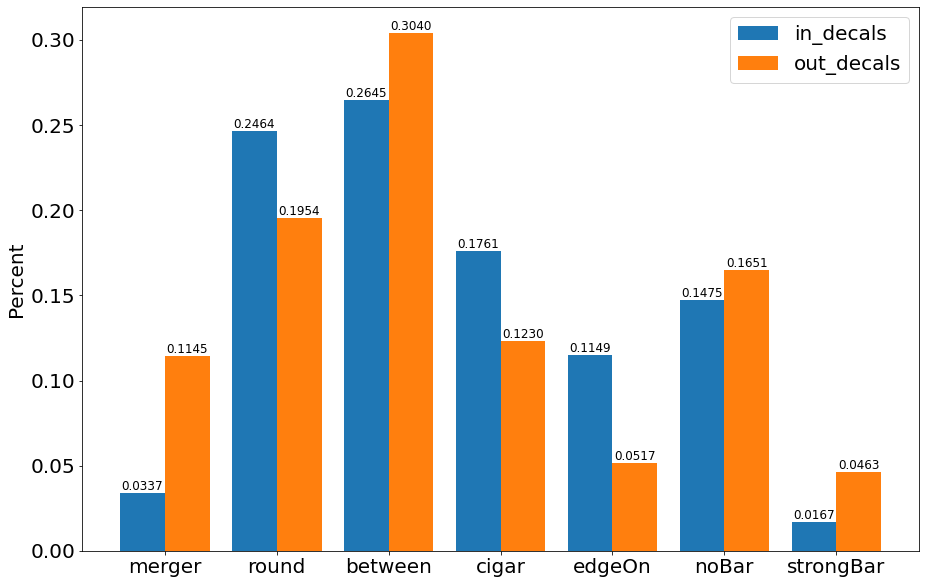

In [11]:
# cut = concat.query("z<0.15")
# num_out=[len(cut.query("label == 0")),
#         len(cut.query("label == 1")),
#         len(cut.query("label == 2")),
#         len(cut.query("label == 3")),
#         len(cut.query("label == 4")),
#         len(cut.query("label == 5")),
#         len(cut.query("label == 6")),
#         ]
# sum_out, sum_in = 0, 0
# for i in num_in:
#     sum_in += i
# for i in num_out:
#     sum_out += i
# percent_in_decals = [x/sum_in for x in num_in]
# percent_out_decals = [x/sum_out for x in num_out]
# width = 0.4
# x = np.arange(len(labels))
# fig, ax = plt.subplots(figsize=(15, 10))
# rects1 = ax.bar(x - width/2, percent_in_decals, width, label='in_decals')
# rects2 = ax.bar(x + width/2, percent_out_decals, width, label='out_decals')
# ax.set_ylabel('Percent', fontsize=20)
# # ax.set_title('percent of in/out decals prediction')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# for a,b in zip(x,percent_in_decals): ##控制标签位置
#     plt.text(a-width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
# for a,b in zip(x,percent_out_decals): ##控制标签位置
#     plt.text(a+width/2,b,'%.4f'%b,ha = 'center',va = 'bottom',fontsize=12)
# ax.legend(fontsize=20)
# # plt.xlabel("class", fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.show()

In [32]:
in_decals = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)

In [38]:
merger_in = in_decals.query("label == 0")
round_in = in_decals.query("label == 1")
between_in = in_decals.query("label == 2")
cigar_in = in_decals.query("label == 3")
edgeOn_in = in_decals.query("label == 4")
noBar_in = in_decals.query("label == 5")
strongBar_in = in_decals.query("label == 6")

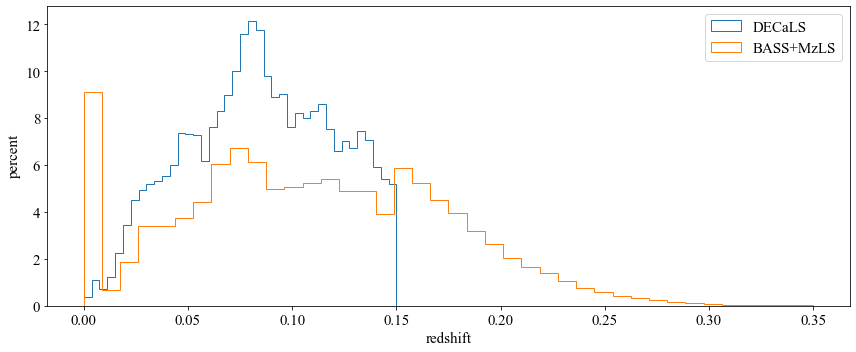

In [57]:
plt.rc('font',family='Times New Roman')
plt.figure(figsize=(12, 5))
plt.hist(in_decals.redshift, range=(1e-5, 0.15), histtype="step", label = "DECaLS", bins=40, density=True)
plt.hist(concat.z, histtype="step", range=(0, 0.35), label = "BASS+MzLS", bins=40, density=True)
plt.xlabel("redshift", fontsize=15)
plt.ylabel("percent", fontsize=15)
plt.legend(loc="best", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()